# Housing data

In this assignment, you'll analyze a collection of data sets from the [San Francisco Open Data Portal](http://data.sfgov.org/) and [Zillow](https://www.zillow.com/). The data sets have been stored in the SQLite database `sf_data.sqlite`, which you can [download here](http://anson.ucdavis.edu/~nulle/sf_data.sqlite). The database contains the following tables:

Table                   | Description
----------------------- | -----------
`crime`                 | Crime reports dating back to 2010.
`mobile_food_locations` | List of all locations where mobile food vendors sell.
`mobile_food_permits`   | List of all mobile food vendor permits. More details [here](https://data.sfgov.org/api/views/rqzj-sfat/files/8g2f5RV4PEk0_b24iJEtgEet9gnh_eA27GlqoOjjK4k?download=true&filename=DPW_DataDictionary_Mobile-Food-Facility-Permit.pdf).
`mobile_food_schedule`  | Schedules for mobile food vendors.
`noise`                 | Noise complaints dating back to August 2015.
`parking`               | List of all parking lots.
`parks`                 | List of all parks.
`schools`               | List of all schools.
`zillow`                | Zillow rent and housing statistics dating back to 1996. More details [here](https://www.zillow.com/research/data/).

The `mobile_food_` tables are explicitly connected through the `locationid` and `permit` columns. The other tables are not connected, but you may be able to connect them using dates, latitude/longitude, or postal codes.

Shapefiles for US postal codes are available [here](https://www.census.gov/geo/maps-data/data/cbf/cbf_zcta.html). These may be useful for converting latitude/longitude to postal codes.

Shapefiles for San Francisco Neighborhoods are available [here](https://data.sfgov.org/Geographic-Locations-and-Boundaries/SF-Find-Neighborhoods/pty2-tcw4).

In [1]:
import sqlite3 as sql
import pandas as pd

In [2]:
db = sql.connect("/Users/yilanliu/Documents/GitHub/STA-141B/141b-hw5--CaseyLiu1207/sf_data.sqlite")
pd.read_sql("SELECT * FROM mobile_food_locations LIMIT 3", db)


,locationid,LocationDescription,Address,Latitude,Longitude
0,762182,TOWNSEND ST: 05TH ST to 06TH ST (400 - 499),444 TOWNSEND ST,37.774871,-122.398532
1,437211,MISSOURI ST: 20TH ST to SIERRA ST (500 - 630),555 MISSOURI ST,37.759304,-122.395902
2,765880,17TH ST: SAN BRUNO AVE to UTAH ST (2200 - 2299),2222 17TH ST,37.765216,-122.406007


In [3]:
food_schdule = pd.read_sql("SELECT * FROM mobile_food_schedule", db)
loc_permit = food_schdule [["locationid", "permit"]]
loc_permit.head()

,locationid,permit
0,305727,11MFF-0040
1,305727,11MFF-0040
2,305727,11MFF-0040
3,305727,11MFF-0040
4,305727,11MFF-0040


In [4]:
loc_permit_1 = loc_permit.groupby(loc_permit.columns.tolist()).size().reset_index().rename(columns={0:'count for one permit in one location'})
loc_permit_1  
permit_count = loc_permit_1[["permit"]]
permit_count = permit_count.groupby(permit_count.columns.tolist()).size().reset_index().rename(columns={0:'count for location'})
permit_count
permit_count.sort_values(["count for location"],ascending=False).head()


,permit,count for location
169,17MFF-0110,58
170,17MFF-0111,37
7,13MFF-0102,37
149,17MFF-0090,33
78,16MFF-0051,23


In [5]:
vender_max_loc = pd.read_sql("SELECT * FROM mobile_food_permits WHERE permit = '17MFF-0110' OR permit = '17MFF-0111' OR permit = '13MFF-0102' OR permit = '17MFF-0090' OR permit = '16MFF-0051'", db)
vender_max_loc

,permit,Status,Applicant,FacilityType,FoodItems,PriorPermit,Approved,Expiration
0,13MFF-0102,EXPIRED,Natan's Catering,Truck,Burgers: melts: hot dogs: burritos:sandwiches:...,1,2013-04-12 12:00:00,2014-03-15 12:00:00
1,16MFF-0051,APPROVED,Park's Catering,Truck,Cold Truck: Hamburger: cheeseburgers: hot dogs...,1,2016-03-15 12:00:00,2017-03-15 12:00:00
2,17MFF-0110,REQUESTED,May Catering,Truck,Cold Truck: Sandwiches: fruit: snacks: candy: ...,1,None,2018-05-06 12:00:00
3,17MFF-0111,REQUESTED,Anas Goodies Catering,Truck,Cold Truck: Sandwiches: Noodles: Pre-packaged...,1,None,2018-03-04 12:00:00
4,17MFF-0090,REQUESTED,Liang Bai Ping,Truck,Cold Truck: Pre-packaged sandwiches: snacks: f...,1,None,2018-03-17 12:00:00


_Thus the top 5 venders sells at the most locations are both trucks. Most of them are cold trucks and sales sandwiches and hambugers._ 

In [6]:
import geopandas as gpd
import fiona
import osmnx as ox 
import matplotlib.pyplot as plt

In [7]:
import shapely.geometry as geom

In [8]:
map1 = gpd.read_file("/Users/yilanliu/Documents/GitHub/STA-141B/141b-hw5--CaseyLiu1207/cb_2016_us_zcta510_500k/cb_2016_us_zcta510_500k.shp")

In [9]:
sf_neighborhood = gpd.read_file("/Users/yilanliu/Downloads/SF Find Neighborhoods/geo_export_b2b63f23-b425-4292-89cf-de00a43e6f23.shp")

__1.)  Which parts of the city are the most and least expensive?__

### Analysis
   
    In the given datasets, only zillow file contains information related to price of commodities, i.e. housing price, thus the first question will be only focusing on zillow file. In zillow file, ZRI per Sq Ft represents rent price and MedianSoldPricePerSqft_AllHomes represents sales price, thus we need to discuss rent and sale price seperately first, and then combine them together to determine which parts of the city are the most expensive. 



In [10]:
map_geoid_loc = map1[['GEOID10','geometry']]
map_geoid_loc.head()

,GEOID10,geometry
0,21914,"POLYGON ((-75.99444799999999 39.567742, -75.99..."
1,01001,"POLYGON ((-72.667677 42.045022, -72.657715 42...."
2,34736,"(POLYGON ((-81.806163 28.568643, -81.801577999..."
3,46151,"(POLYGON ((-86.398562 39.320829, -86.398125999..."
4,48039,"POLYGON ((-82.61060000000001 42.724669, -82.51..."


In [11]:
#ignore panda warning
pd.options.mode.chained_assignment = None 

zillow = pd.read_sql("SELECT * FROM zillow", db)

In [12]:
rent = zillow [["RegionName","ZriPerSqft_AllHomes"]]
rent = rent.dropna(axis=0, how='any')
rent = rent.groupby('RegionName', as_index=False)['ZriPerSqft_AllHomes'].mean()
rent.columns = ['GEOID10', 'sale_price']
rent['GEOID10'] = rent['GEOID10'].astype(str)

map_geoid_loc['GEOID10'] = map_geoid_loc['GEOID10'].astype(str)
rent_loc = pd.merge(map_geoid_loc,
                 rent,
                 on='GEOID10')


rent_max = rent_loc.sort_values(["sale_price"],ascending=False).reset_index(drop=True)
rent_max_id = rent_max.iloc[0][0]
rent_max_price = rent_max.iloc[0][2]
print ("the max rent id is", rent_max_id, "and the rent price is ",rent_max_price )

rent_min = rent_loc.sort_values(["sale_price"],ascending=True).reset_index(drop=True)
rent_min_id = rent_min.iloc[0][0]
rent_min_price = rent_min.iloc[0][2]
print ("the min rent id is", rent_min_id, "and the rent price is ",rent_min_price )

the max rent id is 94105 and the rent price is  4.279173333333334
the min rent id is 94080 and the rent price is  2.1719999999999997


In [13]:
rent_max = rent_max.head(n=1)
rent_min = rent_min.head(n=1)

In [14]:
sale = zillow [["RegionName","MedianSoldPricePerSqft_AllHomes"]]
sale = sale.dropna(axis=0, how='any')
sale = sale.groupby('RegionName', as_index=False)['MedianSoldPricePerSqft_AllHomes'].mean()
sale.columns = ['GEOID10', 'sale_price']
sale['GEOID10'] = sale['GEOID10'].astype(str)

sale_loc = pd.merge(map_geoid_loc,
                 sale,
                 on='GEOID10')

sale_max = sale_loc.sort_values(["sale_price"],ascending=False).reset_index(drop=True)
sale_max_id = sale_max.iloc[0][0]
sale_max_price = sale_max.iloc[0][2]
print ("the max sale id is", sale_max_id, "and the sale price is ",sale_max_price )

sale_min = sale_loc.sort_values(["sale_price"],ascending=True).reset_index(drop=True)
sale_min_id = sale_min.iloc[0][0]
sale_min_price = sale_min.iloc[0][2]
print ("the min sale id is", sale_min_id, "and the sale price is ",sale_min_price )



the max sale id is 94104 and the sale price is  1336.1285814116
the min sale id is 94124 and the sale price is  297.00804620712154


In [15]:
sale_max = sale_max.head(n=1)
sale_min = sale_min.head(n=1)

### Analysis

    The plot for rent and sale was combined, representing the total housing price in san francisco, the reder, the more expensive. Notice that area closer to financial district are more expensive than the others. 


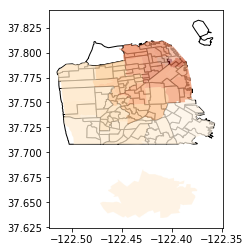

In [16]:
#plot for the 
ax = sf_neighborhood.plot(edgecolor = "black", color = "white")
plot_rent = rent_loc.plot(ax = ax, column = "sale_price",cmap = "OrRd", alpha = 0.5)
plot_sale = sale_loc.plot(ax = ax, column = "sale_price",cmap = "OrRd", alpha = 0.5)


### Analysis
    
    The following graph shows the house renting maximum and minimum price.  The most expensive rent location (marked as green)  corresponds to Union Square, which is a shopping center close to the financial district. Since it is both the center of entertainment in San Francisco, it is resonable to observe Union Square has the most expensive rent. The location has the cheapest rent price is far away from the main city.

/anaconda3/envs/geotest/lib/python3.6/site-packages/geopandas/plotting.py:389: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  "'color'.", UserWarning)


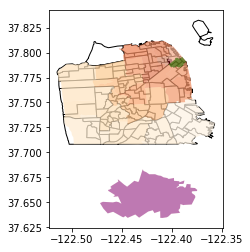

In [17]:
#2. plot the rent sale price 
ax = sf_neighborhood.plot(edgecolor = "black", color = "white")

plot_rent = rent_loc.plot(ax = ax, column = "sale_price",cmap = "OrRd", alpha = 0.5)
plot_sale = sale_loc.plot(ax = ax, column = "sale_price",cmap = "OrRd", alpha = 0.5)
rent_max.plot(ax = ax, column = "sale_price",color = "green", alpha = 0.5)
rent_min.plot(ax = ax, column = "saleh_price",color = "purple", alpha = 0.5)


### Analysis
    
    Similar to previous part, the following graph shows the house sale maximum and minimum price.  The most expensive sale price location (marked as green)  corresponds to financial district. Since it is both the bussiness center in San Francisco, it is resonable to observe it has the most expensive sale price. The location has the cheapest sale price is hunter port. It is not a famous port in san francisco and far away from the business center. 

/anaconda3/envs/geotest/lib/python3.6/site-packages/geopandas/plotting.py:389: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  "'color'.", UserWarning)


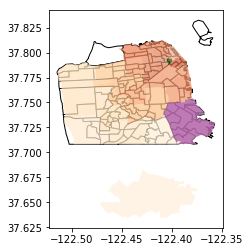

In [18]:
#2. plot the housing sale price 
ax = sf_neighborhood.plot(edgecolor = "black", color = "white")

plot_rent = rent_loc.plot(ax = ax, column = "sale_price",cmap = "OrRd", alpha = 0.5)
plot_sale = sale_loc.plot(ax = ax, column = "sale_price",cmap = "OrRd", alpha = 0.5)
sale_max.plot(ax = ax, column = "sale_price",color = "green", alpha = 0.5)
sale_min.plot(ax = ax, column = "sale_price",color = "purple", alpha = 0.5)



__2.)  Which parts of the city are the most dangerous (and at what times)?__

In [19]:
#1. converting the time inforamtion in crime file into proper format
import pandas as pd


crime = pd.read_sql("SELECT * FROM crime", db)
crime_freq = crime[["DayOfWeek","Datetime","Lon","Lat"]]
crime_freq['Datetime'] = pd.to_datetime(crime_freq['Datetime'],  format="%Y-%m-%d %H:%M:%S")


In [20]:
#2. record the frequency of crime per hour in a day in a new dataframe
crime_freq['hour'] = pd.DatetimeIndex(crime_freq['Datetime']).hour
crime_freq_hour_count = crime_freq[["hour"]]
crime_freq_hour_count = crime_freq_hour_count.groupby(crime_freq_hour_count.columns.tolist()).size().reset_index().rename(columns={0:'count'})
crime_freq_hour_count = crime_freq_hour_count.set_index('hour')

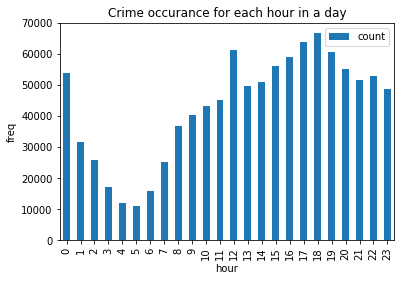

In [21]:
#3.  plot histogram for crime count for each hour 

%matplotlib inline
crime_freq_hour_count.plot.bar()
plt.ylabel('freq')
plt.xlabel('hour')
plt.title('Crime occurance for each hour in a day')
plt.show()

### Analysis
    
    The plot above shows the crime occurance for each hour in a day. Notice that 12pm 17pm 18pm 19pm are the most dangerous time in a day, while as 1am to 8am are the most peaceful time. Lunch break is usually take place around 12pm. Working people usually go out for lunch during that time. 17pm to 19pm is usually the after office rushing hour. After work, people tend to hangout together and doing some entertainment. Thus criminals takes advantage at those time to create chaos. However, during midnight, people tend to stay at home, thus leads to less crime occurence. 

In [22]:
#4. plot for crime frequency map 
lnglat = [geom.Point(x) for x in zip(crime_freq.Lon, crime_freq.Lat)]
crime_freq = gpd.GeoDataFrame(crime_freq, geometry = lnglat)

In [23]:
crime_freq.head()

,DayOfWeek,Datetime,Lon,Lat,hour,geometry
0,Monday,2015-01-19 14:00:00,-122.421582,37.761701,14,POINT (-122.42158168137 37.7617007179518)
1,Sunday,2015-02-01 15:45:00,-122.414406,37.784191,15,POINT (-122.414406029855 37.7841907151119)
2,Sunday,2015-02-01 15:45:00,-122.414406,37.784191,15,POINT (-122.414406029855 37.7841907151119)
3,Sunday,2015-02-01 15:45:00,-122.414406,37.784191,15,POINT (-122.414406029855 37.7841907151119)
4,Tuesday,2015-01-27 19:00:00,-122.431119,37.800469,19,POINT (-122.431118543788 37.8004687042875)


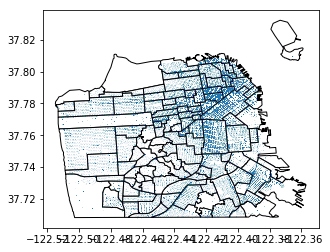

In [24]:
ax = sf_neighborhood.plot(edgecolor = "black", color = "white")
crime_freq.plot(ax = ax, markersize=0.0001,alpha = 0.3)

(37.74, 37.82)

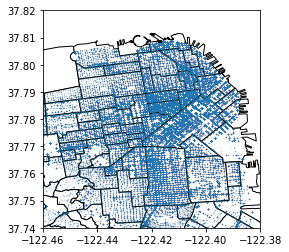

In [25]:
ax = sf_neighborhood.plot(edgecolor = "black", color = "white")
crime_freq.plot(ax = ax, markersize=0.03,alpha = 0.1)
plt.xlim(-122.46, -122.38)
plt.ylim(37.74,37.82)

### Analysis
    
    The above two plots shows the crime occurance on san francisco map. Notice that most of the crime takes place in downtown area, centering around south market, which is the well known scacthy place around Union Square. Since there is always homeless people around with narrow streets. People tends to stay in downtown during daytime (for work or schools). Thus more population leads to a higher crime frequency. 

__3.)  Are noise complaints and mobile food vendors related?__

In [26]:
#1. for noise data first
#(keep column lat lon) drop na if any rows does not have complete lat lon information
noise = pd.read_sql("SELECT * FROM noise", db)
noise_loc = noise [["Lat", "Lon"]]
noise_loc = noise_loc.dropna(axis=0, how='any')

#2. count the noise complaints for each lat lon pair
noise_loc_count = noise_loc.groupby(noise_loc.columns.tolist()).size().reset_index().rename(columns={0:'count'})
noise_loc_count.head()

,Lat,Lon,count
0,37.708331,-122.419122,1
1,37.708415,-122.416303,1
2,37.708978,-122.464534,1
3,37.709264,-122.407027,2
4,37.709414,-122.468197,1


In [27]:
#3. for vendor data 
#sum up the hour with corresponding location id from schdule file

import numpy as np

#ignore panda warning
pd.options.mode.chained_assignment = None 

mobile_food_schedule = pd.read_sql("SELECT * FROM mobile_food_schedule" , db)

# make the hour column as end - start
vender_hour_locid = mobile_food_schedule[["locationid" , "EndHour","StartHour"]]

hour = vender_hour_locid [['EndHour']].sub(vender_hour_locid ['StartHour'], axis=0)
vender_hour_locid [["hour"]] = hour
vender_hour_locid = vender_hour_locid[["locationid" , "hour"]]

# note some hour is negative since the schedule covers 2 days, thus +24 to that hour data
(a,b)=vender_hour_locid.shape
for i in range (1,a):
    if vender_hour_locid.iloc[i-1][1] < 0:
        vender_hour_locid.iloc[i-1][1] = vender_hour_locid.iloc[i-1][1]+24
        
# same locationid multiply hour duration together        
vender_hour_locid = pd.DataFrame(data = vender_hour_locid.groupby('locationid')['hour'].sum())

#notice the locationid was used as index number thus reset the index before merging with location dataframe
vender_hour_locid.reset_index(level=0, inplace=True)
vender_hour_locid.head()

,locationid,hour
0,305727,56
1,305735,56
2,321365,50
3,334914,130
4,338539,30


In [28]:
# 4. find the corresponding lon lat of each location id 
mobile_food_locations = pd.read_sql("SELECT * FROM mobile_food_locations" , db)
mobile_food_locations = mobile_food_locations[["locationid",'Latitude','Longitude']]
mobile_food_locations['locationid'] = mobile_food_locations['locationid'].astype(str)
vender_hour_locid['locationid'] = vender_hour_locid['locationid'].astype(str)


#merge location dataframe with the hour frame
vender_hour_locid_lanlon = pd.merge(mobile_food_locations,
                 vender_hour_locid,
                 on='locationid')

vender_hour_locid_lanlon = vender_hour_locid_lanlon[vender_hour_locid_lanlon.Latitude != 0]

vender_hour_locid_lanlon.head()


,locationid,Latitude,Longitude,hour
0,762182,37.774871,-122.398532,5
1,437211,37.759304,-122.395902,70
2,765880,37.765216,-122.406007,5
3,765690,37.748801,-122.400552,10
4,761933,37.775589,-122.397977,21


In [29]:
#5. plot for noise, the more compalint, the larger the size
lnglat = [geom.Point(x) for x in zip(noise_loc_count.Lon, noise_loc_count.Lat)]
noise_loc_count = gpd.GeoDataFrame(noise_loc_count, geometry = lnglat)

In [30]:
noise_loc_count.head()

,Lat,Lon,count,geometry
0,37.708331,-122.419122,1,POINT (-122.419121651 37.70833078)
1,37.708415,-122.416303,1,POINT (-122.416302995905 37.708414533653)
2,37.708978,-122.464534,1,POINT (-122.46453386204 37.70897807791)
3,37.709264,-122.407027,2,POINT (-122.407027143937 37.709263630449)
4,37.709414,-122.468197,1,POINT (-122.468196509788 37.709413708476)


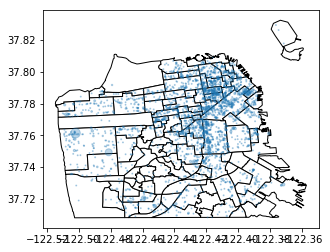

In [31]:
ax = sf_neighborhood.plot(edgecolor = "black", color = "white")
noise_loc_count.plot(ax = ax, markersize=noise_loc_count["count"],alpha = 0.3)

### Analysis
    
    The above plots shows noise complaints occurance in San Francisco, the darker the blue dots, the more complaints that area have. Notice that downtown, most centering around south matket, has more noise complaints than the others. 

In [32]:
#6. plot for vender, the longer the hour, the large the size
lnglat = [geom.Point(x) for x in zip(vender_hour_locid_lanlon.Longitude, vender_hour_locid_lanlon.Latitude)]
vender_hour_locid_lanlon = gpd.GeoDataFrame(vender_hour_locid_lanlon, geometry = lnglat)


In [33]:
vender_hour_locid_lanlon.head()

,locationid,Latitude,Longitude,hour,geometry
0,762182,37.774871,-122.398532,5,POINT (-122.398531708276 37.7748713162388)
1,437211,37.759304,-122.395902,70,POINT (-122.395902231236 37.7593037663834)
2,765880,37.765216,-122.406007,5,POINT (-122.406006972029 37.7652159489938)
3,765690,37.748801,-122.400552,10,POINT (-122.400552458785 37.7488013777145)
4,761933,37.775589,-122.397977,21,POINT (-122.39797690638 37.7755890799594)


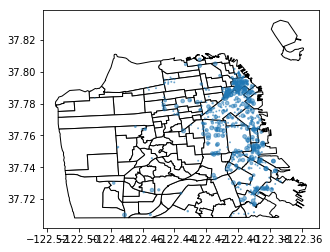

In [34]:
ax = sf_neighborhood.plot(edgecolor = "black", color = "white")
vender_hour_locid_lanlon.plot(ax = ax, markersize=vender_hour_locid_lanlon[["hour"]]/5,alpha=0.5 )

### Analysis
    
    The above plots shows venders in San Francisco, the darker the blue dots, the more venders in that area have. Notice that downtown, most centering around financial district, has more venders than the others.

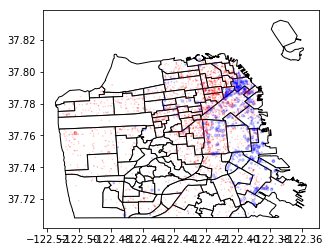

In [35]:
#7. combine 2 plots
ax = sf_neighborhood.plot(edgecolor = "black", color = "white")
noise_loc_count.plot(ax = ax, markersize=noise_loc_count["count"]/10 , color = "red",alpha=0.3)
vender_hour_locid_lanlon.plot(ax = ax, markersize=vender_hour_locid_lanlon[["hour"]]/10, color = "blue",alpha=0.2)

### Analysis
    
    The above plots shows the relationship between noise complaints (marked as red) and venders (marked as blue). Ntoice downtown area has the most concentrated dots, thus the more noise complaints, the more venders in that location. This is reasonable to be observed, since venders represents small bussiness in a city. Downtown area are expected to have the most concentrated small bussinesses, since it has more consumer demands for large population. Small bussiness usually opens in a small spot within buildings or on streets, in order to have large amount potential consumer populations. Thus small bussinesses (i.e. venders) will bring noise to that place since it is not able to provide a fully closed area to serve all customers. And thus high amounts of noise complaints will be expected for area with more venders. 
    

__4.)  What are the best times and places to find food trucks?__

In [36]:
#1. get a dataframe that contains all desire elements (all truck permits, schedule with corresponding location id)
truck_permits = pd.read_sql("SELECT FacilityType, permit FROM mobile_food_permits WHERE FacilityType = 'Truck'" , db)

In [37]:
truck_permit_schdule = pd.merge(truck_permits,
                                 mobile_food_schedule,
                                 on='permit')
truck_permit_schdule.head()

,FacilityType,permit,locationid,DayOfWeek,EndHour,StartHour
0,Truck,16MFF-0027,762178,Mo,9,6
1,Truck,16MFF-0027,762178,Tu,9,6
2,Truck,16MFF-0027,762178,We,9,6
3,Truck,16MFF-0027,762178,Th,9,6
4,Truck,16MFF-0027,762178,Fr,9,6


In [38]:
food_loc = pd.read_sql("SELECT locationid,Latitude,Longitude  FROM mobile_food_locations" , db)
food_loc.head()

,locationid,Latitude,Longitude
0,762182,37.774871,-122.398532
1,437211,37.759304,-122.395902
2,765880,37.765216,-122.406007
3,765690,37.748801,-122.400552
4,751253,37.767852,-122.416105


In [39]:
truck_permit_schdule_lon_lat = pd.merge(truck_permit_schdule,
                                         food_loc,
                                         on='locationid')
truck_permit_schdule_lon_lat = truck_permit_schdule_lon_lat[["permit", "locationid", "EndHour", "StartHour", "Latitude","Longitude"]]
truck_permit_schdule_lon_lat.head()

,permit,locationid,EndHour,StartHour,Latitude,Longitude
0,16MFF-0027,762178,9,6,37.753109,-122.38817
1,16MFF-0027,762178,9,6,37.753109,-122.38817
2,16MFF-0027,762178,9,6,37.753109,-122.38817
3,16MFF-0027,762178,9,6,37.753109,-122.38817
4,16MFF-0027,762178,9,6,37.753109,-122.38817


In [40]:
#2. for the best location to find food truck

#a.) get the count for permit_location pair 
#    and use it as reference of how many times a food truck appears in that location
truck_permit_locid_paircount = truck_permit_schdule_lon_lat.groupby(['permit',"locationid"]).size().reset_index(name='permit_location_pair_count')
truck_permit_locid_paircount.head()

,permit,locationid,permit_location_pair_count
0,11MFF-0040,305727,14
1,11MFF-0040,305735,14
2,11MFF-0177,338539,3
3,11MFF-0177,338548,3
4,13MFF-0094,429253,5


In [41]:
#b.) get the location with lat and log information corresponding to each location id 
truck_permit_locid_paircount_lon_lat = pd.merge(truck_permit_locid_paircount,
                                         food_loc,
                                         on='locationid')
truck_permit_locid_paircount_lon_lat = truck_permit_locid_paircount_lon_lat[truck_permit_locid_paircount_lon_lat.Latitude != 0]
truck_permit_locid_paircount_lon_lat.head()

,permit,locationid,permit_location_pair_count,Latitude,Longitude
1,11MFF-0040,305735,14,37.786206,-122.402532
2,11MFF-0177,338539,3,37.795701,-122.398490
3,11MFF-0177,338548,3,37.797455,-122.399011
4,13MFF-0094,429253,5,37.732794,-122.391768
5,13MFF-0102,437190,5,37.767433,-122.392149


In [42]:
# c.) plot food truck occurence plot
 v


,permit,locationid,permit_location_pair_count,Latitude,Longitude,geometry
1,11MFF-0040,305735,14,37.786206,-122.402532,POINT (-122.402532491346 37.7862060821039)
2,11MFF-0177,338539,3,37.795701,-122.398490,POINT (-122.398489753587 37.7957009053169)
3,11MFF-0177,338548,3,37.797455,-122.399011,POINT (-122.399011222821 37.7974551567824)
4,13MFF-0094,429253,5,37.732794,-122.391768,POINT (-122.391768324832 37.7327944920286)
5,13MFF-0102,437190,5,37.767433,-122.392149,POINT (-122.392149114172 37.76743301733121)


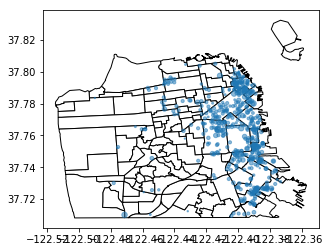

In [43]:
ax = sf_neighborhood.plot(edgecolor = "black", color = "white")
truck_permit_locid_paircount_lon_lat.plot(ax = ax, markersize=truck_permit_locid_paircount_lon_lat[["permit_location_pair_count"]]*2,alpha = 0.5 )

(37.72, 37.81)

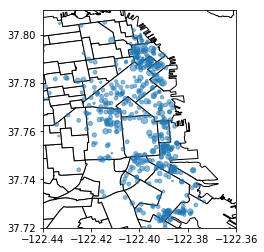

In [44]:
ax = sf_neighborhood.plot(edgecolor = "black", color = "white")
truck_permit_locid_paircount_lon_lat.plot(ax = ax, markersize=truck_permit_locid_paircount_lon_lat[["permit_location_pair_count"]]*3,alpha = 0.5 )
plt.xlim(-122.44, -122.36)
plt.ylim(37.72,37.81)

### Analysis
    
    The above plot shows the food truck location in San Francisco, the darker the blue, the more food truck that area has. Notice that area around Golden Gate and area around Potrero District have the most dense blue dots. Thus this two location are the best spaces to find food trucks. Golden Gate is one of the most famous travel destination in U.S., whereas Potreto District has the most small company office with a dense living populations.

In [45]:
# 3. for the best time to find food truck
#a.) get the dataframe only contains start-end time before analysis
#    then expand the time frame into full time frame
#    i.e. start:5 end:7 full time frame:5,6,7
truck_hour = truck_permit_schdule_lon_lat[["EndHour","StartHour" ]]
truck_hour[["EndHour","StartHour"]] = truck_hour[["EndHour","StartHour"]].apply(pd.to_numeric)
truck_hour.head()

,EndHour,StartHour
0,9,6
1,9,6
2,9,6
3,9,6
4,9,6


In [46]:
truck_hour.shape

(3243, 2)

In [47]:
# b.)  for those 10 location make the duration into full duration
hour_full = []
for i in range (1,3243): 
    end_hour = truck_hour.iloc[i-1][0]
    start_hour = truck_hour.iloc[i-1][1]
    if end_hour < start_hour:
        list_regular_a = list(range(start_hour,23))
        list_regular_b = list(range(0,end_hour+1))
        list_regular = list_regular_a +list_regular_b
    else:
        list_regular = list(range(start_hour,end_hour+1))
    
    hour_full = hour_full + list_regular
  


In [48]:
# c.)  count the freq for each hour
hour_freq = []
for i in range(0,24):
    hour_freq_1 = [hour_full .count(i)]
    hour_freq = hour_freq + hour_freq_1
hour_freq = pd.DataFrame(data = hour_freq, )
hour_freq.columns = ['freq']
hour_freq.head()

,freq
0,684
1,402
2,364
3,356
4,344


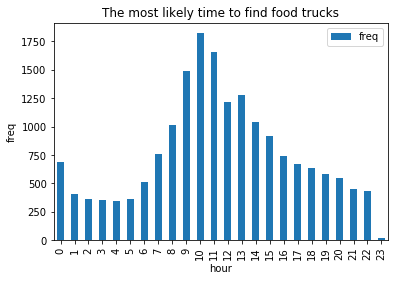

In [49]:
# d.)  plot histogram for hour count 
import matplotlib.pyplot as plt
%matplotlib inline
hour_freq.plot.bar()
plt.ylabel('freq')
plt.xlabel('hour')
plt.title('The most likely time to find food trucks')
plt.show()

### Analysis
    The above plot shows the frequency of food truck for each hour in a day. Notice that 9am, 10am, 11am has the highest frequency overall, and reaches maximum at around 10am. Most of office start at arounf 9am, thus people tends to grab their breakfast around 8am to 10am. The lunch break is around 12am, thus people tends to grab their luncg around 10am to 1pm. Thus 9am to 11am has breakfast time and lunch time overlapse, and 10am was expected to have the most amount of costomers for food, thus food trucks will choose to operate during those hours.

__5.)  Is there a relationship between housing prices and any of the other tables?__

(37.7, 37.84)

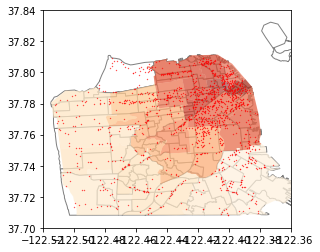

In [50]:
#1. plot for parking spot and housing price
parking = pd.read_sql("SELECT Lat, Lon FROM parking", db)
lnglat = [geom.Point(x) for x in zip(parking.Lon, parking.Lat)]
parking = gpd.GeoDataFrame(parking, geometry = lnglat)
ax = sf_neighborhood.plot(color = "white", edgecolor = "gray")
plot_sale = sale_loc.plot(ax = ax, column = "sale_price",cmap = "OrRd", alpha = 0.5)
plot_rent = rent_loc.plot(ax = ax, column = "sale_price",cmap = "OrRd", alpha = 0.5)
parking_plot = parking.plot(ax = ax,color = "red",markersize = 0.1)
plt.xlim(-122.52, -122.36)
plt.ylim(37.70,37.84)

### Analysis
    
    The plot above shows the relationship between parking spots and housing price. Notice the higher the housinf price, the more parking spots that area has. Higher housing price corresponds to higher cosumer needs, and  economic prosperity around that area, thus it is resonable to observe more parking spots.

(37.7, 37.84)

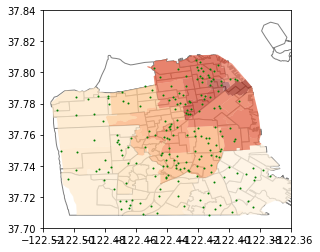

In [51]:
#2. plot for price and parks
parks = pd.read_sql("SELECT Lat, Lon FROM parks", db)
parks = parks.dropna(axis=0, how='any', thresh=None, subset=None, inplace=False)
lnglat = [geom.Point(x) for x in zip(parks.Lon, parks.Lat)]
parks = gpd.GeoDataFrame(parks, geometry = lnglat)
ax = sf_neighborhood.plot(color = "white", edgecolor = "gray")
plot_sale = sale_loc.plot(ax = ax, column = "sale_price",cmap = "OrRd", alpha = 0.5)
plot_rent = rent_loc.plot(ax = ax, column = "sale_price",cmap = "OrRd", alpha = 0.5)
parks.plot(ax = ax,color = "green",markersize = 1)
plt.xlim(-122.52, -122.36)
plt.ylim(37.70,37.84)

### Analysis
    
    The plot above shows the relationship between parks and housing price. Notice that there is no obvious relationship between parks location and housing price, since parks tends to disperse evenly on the map.

(37.7, 37.84)

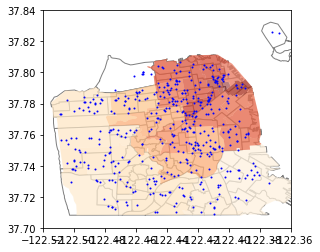

In [52]:
#3. plot for price and schools
schools = pd.read_sql("SELECT Lat, Lon FROM schools", db)
lnglat = [geom.Point(x) for x in zip(schools.Lon, schools.Lat)]
schools = gpd.GeoDataFrame(schools, geometry = lnglat)
ax = sf_neighborhood.plot(color = "white", edgecolor = "gray")
plot_sale = sale_loc.plot(ax = ax, column = "sale_price",cmap = "OrRd", alpha = 0.5)
plot_rent = rent_loc.plot(ax = ax, column = "sale_price",cmap = "OrRd", alpha = 0.5)
schools.plot(ax = ax,color = "blue",markersize = 1)
plt.xlim(-122.52, -122.36)
plt.ylim(37.70,37.84)

### Analysis
    
    The plot above shows the relationship between schools and housing price. Similar to above image, there is no obvious relationship between school location and housing price, since school tends to disperse evenly on the map. It is reasonable to observe that, since school and park location was tends to be determined by the government, who wants the citizens have equal rights to access education and recreation avtivities, thus housing price would not have direct relationship with location of parks nor school. 

(37.7, 37.84)

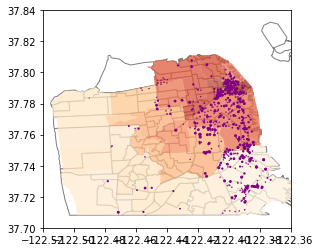

In [53]:
#4. plot for price and vender locations
ax = sf_neighborhood.plot(color = "white", edgecolor = "gray")
plot_sale = sale_loc.plot(ax = ax, column = "sale_price",cmap = "OrRd", alpha = 0.5)
plot_rent = rent_loc.plot(ax = ax, column = "sale_price",cmap = "OrRd", alpha = 0.5)
vender_hour_locid_lanlon.plot(ax = ax, color = "purple", markersize=vender_hour_locid_lanlon[["hour"]]/20 )
plt.xlim(-122.52, -122.36)
plt.ylim(37.70,37.84)

### Analysis
    
    The plot above shows the relationship between venders and housing price. Notice the higher the housing price, the more venders in that area. Venders represents small bussinesses, and housing price represents level of economics prosperity of that area. Thus the higer housing price, the more small bussiness (venders) in that area.

(37.7, 37.84)

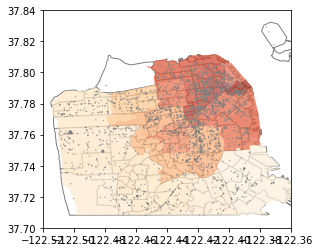

In [54]:
#5. plot for price and noise complain
ax = sf_neighborhood.plot(color = "white", edgecolor = "gray")
plot_sale = sale_loc.plot(ax = ax, column = "sale_price",cmap = "OrRd", alpha = 0.5)
plot_rent = rent_loc.plot(ax = ax, column = "sale_price",cmap = "OrRd", alpha = 0.5)
noise_loc_count.plot(ax = ax, color = "gray", markersize=noise_loc_count["count"]/10)
plt.xlim(-122.52, -122.36)
plt.ylim(37.70,37.84)

### Analysis
    
    The plot above shows the relationship between noise complaints and housing price. Notice the higher the housing price, the more noise complaints in that area. 

(37.7, 37.84)

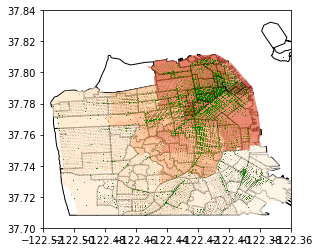

In [55]:
#6. plot for price and crime
ax = sf_neighborhood.plot(edgecolor = "black", color = "white")
plot_sale = sale_loc.plot(ax = ax, column = "sale_price",cmap = "OrRd", alpha = 0.5)
plot_rent = rent_loc.plot(ax = ax, column = "sale_price",cmap = "OrRd", alpha = 0.5)
crime_freq.plot(ax = ax, markersize=0.00001, color = "green", alpha = 0.5)
plt.xlim(-122.52, -122.36)
plt.ylim(37.70,37.84)

### Analysis
    
    The plot above shows the relationship between crimes and housing price. Notice the higher the housing price, the more crime occurance in that area. It is reasonable to observe both noise compalints and crimes has positive relationship with housing price, since area with high prosperity level usually has more populations. Large population will cause high frequency of chaos. 